# Expedia hotel recommendations with Apache Spark

The size of the train set is 3.8 GB, with more than 37 million samples! That is why I will be using Pyspark instead of our favorite Pandas! When possible for visualization I will be using toPandas() command to convert pyspark dataframes to pandas. 

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pyspark.sql
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
from pyspark.sql.functions import count
import seaborn as sns

In [3]:
spark = SparkSession.builder.getOrCreate()

## 1. Import and Explore

### 1.1. Import:

In [129]:
train = spark.read.csv('../data/input/train.csv', header=True)
test = spark.read.csv('../data/input/test.csv', header=True)

### 1.2 Explore

What attriutes we have?

In [5]:
train.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: string (nullable = true)
 |-- posa_continent: string (nullable = true)
 |-- user_location_country: string (nullable = true)
 |-- user_location_region: string (nullable = true)
 |-- user_location_city: string (nullable = true)
 |-- orig_destination_distance: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- is_mobile: string (nullable = true)
 |-- is_package: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: string (nullable = true)
 |-- srch_children_cnt: string (nullable = true)
 |-- srch_rm_cnt: string (nullable = true)
 |-- srch_destination_id: string (nullable = true)
 |-- srch_destination_type_id: string (nullable = true)
 |-- is_booking: string (nullable = true)
 |-- cnt: string (nullable = true)
 |-- hotel_continent: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 

In [6]:
test.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_time: string (nullable = true)
 |-- site_name: string (nullable = true)
 |-- posa_continent: string (nullable = true)
 |-- user_location_country: string (nullable = true)
 |-- user_location_region: string (nullable = true)
 |-- user_location_city: string (nullable = true)
 |-- orig_destination_distance: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- is_mobile: string (nullable = true)
 |-- is_package: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: string (nullable = true)
 |-- srch_children_cnt: string (nullable = true)
 |-- srch_rm_cnt: string (nullable = true)
 |-- srch_destination_id: string (nullable = true)
 |-- srch_destination_type_id: string (nullable = true)
 |-- hotel_continent: string (nullable = true)
 |-- hotel_country: string (nullable = true)
 |-- hotel_market: string (nullable = true)


How many samples does the train data include?

In [7]:
n_train = train.count()
print(n_train)

37670293


Quite big! Around 38 millions!

How many samples does the test data include? 

In [8]:
test.count()

2528243

**First Visualization**:

To see the first five rows of the train set, it is possible to use train.head(5) or train.show(5) (slightly better visualization), but still it can be quite hard to get a sense of the data. Instead, I use Pandas:

In [9]:
pd.DataFrame(train.head(5), columns=train.columns)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


Similarly, for .describe():

In [10]:
train.describe().toPandas()

,summary,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,count,37670293,37670293,37670293,37670293,37670293,37670293,24145292,37670293,37670293,...,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293,37670293
1,mean,None,9.795271329585889,2.6804730188851997,86.10880194109454,308.4060117610447,27753.044729330883,1970.0900267207285,604451.7531778422,0.1349265056154461,...,0.3321221579030458,1.1126628083301608,14441.090543760836,2.5822799148389954,0.07965674702875288,1.4833839227106622,3.1563047837190967,81.29685165974153,600.461883638654,49.80860501934509
2,stddev,None,11.9675435665128,0.7480393482506577,59.24310334783878,208.44374973856722,16782.553195680346,2232.4424303904275,350617.4620408585,0.34164505966916764,...,0.7314980986397146,0.45911549963856946,11066.302332627309,2.153018959399955,0.2707610600283715,1.2197755786558424,1.6231886782105662,56.171188062887815,511.73912727922396,28.915950805004293
3,min,2013-01-07 00:00:02,10,0,0,0,0,0.0056,0,0,...,0,0,0,0,0,1,0,0,0,0
4,max,2014-12-31 23:59:59,9,4,99,999,9998,9999.9984,999999,1,...,9,8,9999,9,1,99,6,99,999,99


What are the feature types? 

In [11]:
train.dtypes

[('date_time', 'string'),
 ('site_name', 'string'),
 ('posa_continent', 'string'),
 ('user_location_country', 'string'),
 ('user_location_region', 'string'),
 ('user_location_city', 'string'),
 ('orig_destination_distance', 'string'),
 ('user_id', 'string'),
 ('is_mobile', 'string'),
 ('is_package', 'string'),
 ('channel', 'string'),
 ('srch_ci', 'string'),
 ('srch_co', 'string'),
 ('srch_adults_cnt', 'string'),
 ('srch_children_cnt', 'string'),
 ('srch_rm_cnt', 'string'),
 ('srch_destination_id', 'string'),
 ('srch_destination_type_id', 'string'),
 ('is_booking', 'string'),
 ('cnt', 'string'),
 ('hotel_continent', 'string'),
 ('hotel_country', 'string'),
 ('hotel_market', 'string'),
 ('hotel_cluster', 'string')]

The read.csv() function of pyspark read all the features as string! So, we convert them appropriately:

In [12]:
print(train.columns, "\n")
print("The train set has", len(train.columns), "columns.")

['date_time', 'site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster'] 

The train set has 24 columns.


In [130]:
int_columns = ['site_name', 'posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 
               'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt',
               'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 
               'hotel_market', 'hotel_cluster']
float_columns = ['orig_destination_distance']
date_columns = ['date_time', 'srch_ci', 'srch_co']

In [131]:
for i in range(len(int_columns)):
    train = train.withColumn(int_columns[i], train[int_columns[i]].astype('int'))
for i in range(len(float_columns)):
    train = train.withColumn(float_columns[i], train[float_columns[i]].astype('float'))

Let's now check the types:

In [15]:
train.dtypes

[('date_time', 'string'),
 ('site_name', 'int'),
 ('posa_continent', 'int'),
 ('user_location_country', 'int'),
 ('user_location_region', 'int'),
 ('user_location_city', 'int'),
 ('orig_destination_distance', 'float'),
 ('user_id', 'int'),
 ('is_mobile', 'int'),
 ('is_package', 'int'),
 ('channel', 'int'),
 ('srch_ci', 'string'),
 ('srch_co', 'string'),
 ('srch_adults_cnt', 'int'),
 ('srch_children_cnt', 'int'),
 ('srch_rm_cnt', 'int'),
 ('srch_destination_id', 'int'),
 ('srch_destination_type_id', 'int'),
 ('is_booking', 'int'),
 ('cnt', 'int'),
 ('hotel_continent', 'int'),
 ('hotel_country', 'int'),
 ('hotel_market', 'int'),
 ('hotel_cluster', 'int')]

** How many are really booking? **

In [16]:
train.where(train.is_booking == 1).count()

3000693

Only around 3 millions of the 38 millions data 'booked', and the rest where only a click! So chance of booking when click is:

In [17]:
print(train.where(train.is_booking == 1).count() / train[train.is_booking.isNotNull()].count() * 100, '%')

7.965674702875288 %


So, only **8%** of the train data is booking and the rest are clicks! 

In [18]:
print("train data summary:\n",
      train.select('user_location_country').distinct().count(), "user countries\n", 
      train.select('user_location_city').distinct().count(), "user cities\n", 
      train.select('hotel_country').distinct().count(), "hotel countries\n",
      train.select('hotel_cluster').distinct().count(), "hotel clusters\n",
      train.select('srch_destination_type_id').distinct().count(), "search destination types\n", 
      train.select('user_id').distinct().count(), "distinct users")

train data summary:
 237 user countries
 50447 user cities
 213 hotel countries
 100 hotel clusters
 10 search destination types
 1198786 distinct users


So only ~1.2 millions users generate the ~38 millions logs!

Are there any users in common in train-test sets? 

Since there exists only 1.2 different users and average cnt (number of clicks in a Session) is only ~1.5, that would mean that the logs of the same users has been recorded in different sessions or different srch_destination_ids. 

In [20]:
pd.DataFrame(train.head(5), columns=train.columns)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.264160,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.264160,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.264160,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.193176,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.625916,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [21]:
train.select('is_booking').rdd.map(lambda row : row.is_booking).take(30);

In [22]:
test.describe().toPandas()

,summary,id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,...,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market
0,count,2528243,2528243,2528243,2528243,2528243,2528243,2528243,1680782,2528243,...,2528222,2528226,2528243,2528243,2528243,2528243,2528243,2528243,2528243,2528243
1,mean,1264121.0,None,9.70966556616591,2.697412788248598,85.51611929707705,317.0340683233376,27862.17806318459,1686.3979638184105,602645.9257690024,...,None,None,1.958126651591639,0.25074132510205704,1.117409995795499,16568.621168139296,2.941701806353266,3.022614914784694,81.25454277931354,646.4925847713214
2,stddev,729841.0326509465,None,12.271834283602896,0.7651287624994623,56.73879902333156,208.28338881273413,16687.877645606164,2197.361433047482,346965.11778565275,...,None,None,0.8980415286253776,0.6754566222733871,0.4615009555032746,12805.019853860984,2.282005929487735,1.6748793299399136,55.07528338943058,504.65298547297846
3,min,0,2015-01-08 00:00:35,0,0,0,0,0,0.0056,0,...,2015-01-04,2015-01-08,0,0,0,10,1,0,0,0
4,max,999999,2015-12-31 23:58:47,9,4,99,999,9999,9999.9851,999999,...,2161-10-00,2017-04-30,9,9,8,9999,9,6,99,999


### 1.3 Missing data

In [171]:
for c in train.columns:
    print(c, ' ', train.where(col(c).isNull()).count())

date_time   0
site_name   0
posa_continent   0
user_location_country   0
user_location_region   0
user_location_city   0
orig_destination_distance   13525001
user_id   0
is_mobile   0
is_package   0
channel   0
srch_ci   47083
srch_co   47084
srch_adults_cnt   0
srch_children_cnt   0
srch_rm_cnt   0
srch_destination_id   0
srch_destination_type_id   0
is_booking   0
cnt   0
hotel_continent   0
hotel_country   0
hotel_market   0
hotel_cluster   0


There exists three features with null values, namely orig_destination_distance, search check in, and search check out. Since, the proportion of missing srch_ci and srch_co is very small compared to the total data (only ~47000 out of 37 million!) we drop the rows with missing srch_ci or srch_co. 

In [30]:
for c in test.columns:
    print(c , ' ', test.where(col(c).isNull()).count())

id   0
date_time   0
site_name   0
posa_continent   0
user_location_country   0
user_location_region   0
user_location_city   0
orig_destination_distance   847461
user_id   0
is_mobile   0
is_package   0
channel   0
srch_ci   21
srch_co   17
srch_adults_cnt   0
srch_children_cnt   0
srch_rm_cnt   0
srch_destination_id   0
srch_destination_type_id   0
hotel_continent   0
hotel_country   0
hotel_market   0


In [50]:
pd.DataFrame(train.withColumn('srch_ci_yr', train['srch_ci'][0:4].astype("int")).head(5), columns=train.columns + ['srch_ci_yr'])['srch_ci_yr']

0    2014
1    2014
2    2014
3    2014
4    2014
Name: srch_ci_yr, dtype: int64

In [91]:
pd.DataFrame(train.withColumn('srch_ci_mn', train['srch_ci'][5:4][2:2]).head(5), columns=train.columns + ['srch_ci_mn'])['srch_ci_mn']

0    08
1    08
2    08
3    11
4    11
Name: srch_ci_mn, dtype: object

In [ ]:
pd.DataFrame(train.withColumn('srch_ci_mn', train['srch_ci'][9:9]).head(5), columns=train.columns + ['srch_ci_mn'])['srch_ci_mn']

In [132]:
train = train.withColumn('srch_ci_yr', train['srch_ci'][0:4].astype("int"))
train = train.withColumn('srch_ci_mn', train['srch_ci'][5:4][2:2].astype("int"))
train = train.withColumn('srch_ci_dy', train['srch_ci'][9:9].astype("int"))

In [138]:
train = train.select(train.columns[0:23] + train.columns[24:] + ['hotel_cluster'])

In [139]:
train.columns

['date_time',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_ci',
 'srch_co',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_ci_yr',
 'srch_ci_mn',
 'srch_ci_dy',
 'hotel_cluster']

In [96]:
pd.DataFrame(train.head(5), columns=train.columns)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,srch_ci_yr,srch_ci_mn,srch_ci_dy
0,2014-08-11 07:46:59,2,3,66,348,48862,12,0,1,9,...,1,0,3,2,50,628,1,2014,8,27
1,2014-08-11 08:22:12,2,3,66,348,48862,12,0,1,9,...,1,1,1,2,50,628,1,2014,8,29
2,2014-08-11 08:24:33,2,3,66,348,48862,12,0,0,9,...,1,0,1,2,50,628,1,2014,8,29
3,2014-08-09 18:05:16,2,3,66,442,35390,93,0,0,3,...,1,0,1,2,50,1457,80,2014,11,23
4,2014-08-09 18:08:18,2,3,66,442,35390,93,0,0,3,...,1,0,1,2,50,1457,21,2014,11,23


In [140]:
train = train.where(col('srch_ci').isNotNull() & col('srch_co').isNotNull())

In [141]:
train_head = pd.DataFrame(train.head(5), columns=train.columns)

In [142]:
train = train.drop('orig_destination_distance')

In [143]:
train.printSchema()

root
 |-- date_time: string (nullable = true)
 |-- site_name: integer (nullable = true)
 |-- posa_continent: integer (nullable = true)
 |-- user_location_country: integer (nullable = true)
 |-- user_location_region: integer (nullable = true)
 |-- user_location_city: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- is_mobile: integer (nullable = true)
 |-- is_package: integer (nullable = true)
 |-- channel: integer (nullable = true)
 |-- srch_ci: string (nullable = true)
 |-- srch_co: string (nullable = true)
 |-- srch_adults_cnt: integer (nullable = true)
 |-- srch_children_cnt: integer (nullable = true)
 |-- srch_rm_cnt: integer (nullable = true)
 |-- srch_destination_id: integer (nullable = true)
 |-- srch_destination_type_id: integer (nullable = true)
 |-- is_booking: integer (nullable = true)
 |-- cnt: integer (nullable = true)
 |-- hotel_continent: integer (nullable = true)
 |-- hotel_country: integer (nullable = true)
 |-- hotel_market: integer (nullable = t

## 2. Feature engineering

For Exploratory Data Analysis (EDA), working with the large data, and especially visuallizing the data is almost impossible. Instead we will be using a random sample of 1 % of the data for EDA. 

In [144]:
sample_train_pd = train.sample(False, 0.01).toPandas()
# only the users with is_booking = 1
sample_trainB_pd = train.where(train.is_booking == 1).sample(False, 0.1).toPandas()
sample_trainB_pd['is_booking'] = 1
# users with is_booking = 0
sample_trainNB_pd = train.where(train.is_booking == 0).sample(False, 0.01).toPandas()
sample_trainNB_pd['is_booking'] = 0

In [28]:
test_pd = test.sample(False, 0.5).toPandas()

The size of the sampled train data is:

In [26]:
sample_train_pd.shape

(376911, 24)

In [27]:
print("The ratio of booking to all in the sampled train data is", len(sample_train_pd.loc[sample_train_pd['is_booking'] == 1]) / len(sample_train_pd) * 100, " %.")

The ratio of booking to all in the sampled train data is 7.9334378672949315  %.


In [28]:
print("The ration of booking to all in all train data is", train.where(train.is_booking == 1).count() / train[train.is_booking.isNotNull()].count() * 100, '%.')

The ration of booking to all in all train data is 7.965674702875288 %.


Text(0.5,0,'Hotel Clusters')

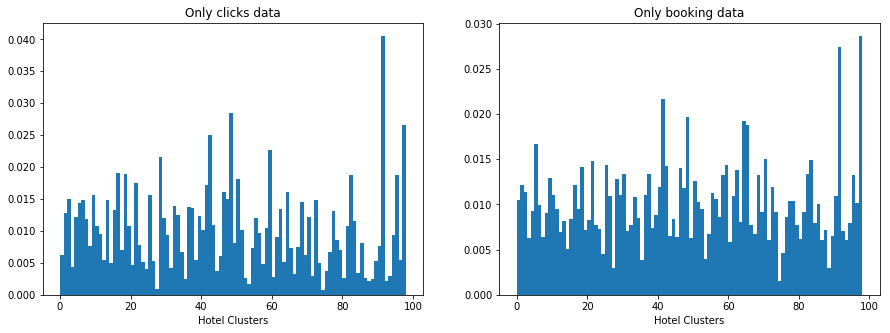

In [30]:
plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.hist(sample_trainB_pd['hotel_cluster'], bins = range(0, 99), density = True)
plt.title('Only clicks data')
plt.xlabel('Hotel Clusters')
plt.subplot(1, 2, 2)
plt.hist(sample_trainNB_pd['hotel_cluster'], bins = range(0, 99), density= True)
plt.title('Only booking data')
plt.xlabel('Hotel Clusters')

The distribution of the selected hotel clusters in the only-book-data is different from only-click-data. Given that the test data is only on booking data, the question is should we only use only-book-data? To better answer this question, we do a more systematic comparison between only-book and only-click data.

In [31]:
hotel_cluster_hist_B = np.histogram(sample_trainB_pd['hotel_cluster'], bins = range(99), density=True)
hotel_cluster_hist_NB = np.histogram(sample_trainNB_pd['hotel_cluster'], bins = range(99), density = True)

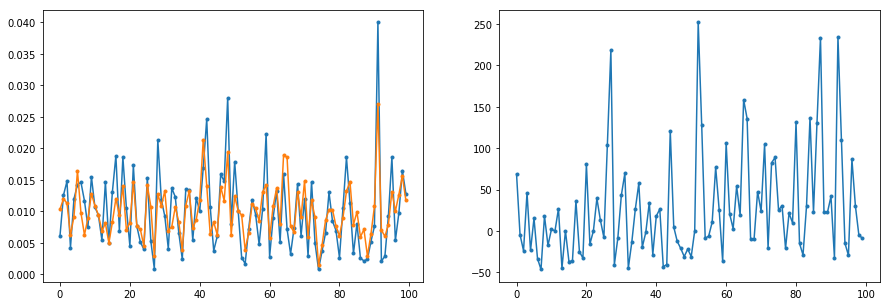

In [33]:
clusterB = sample_trainB_pd['hotel_cluster'].value_counts(normalize = True).sort_index()
clusterNB = sample_trainNB_pd['hotel_cluster'].value_counts(normalize = True).sort_index()

plt.subplots(1, 2, figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(clusterB, '.-')
plt.plot(clusterNB, '.-')
plt.subplot(1, 2, 2)
plt.plot((clusterNB - clusterB) / clusterB * 100, '.-')

In [29]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(20, 18))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

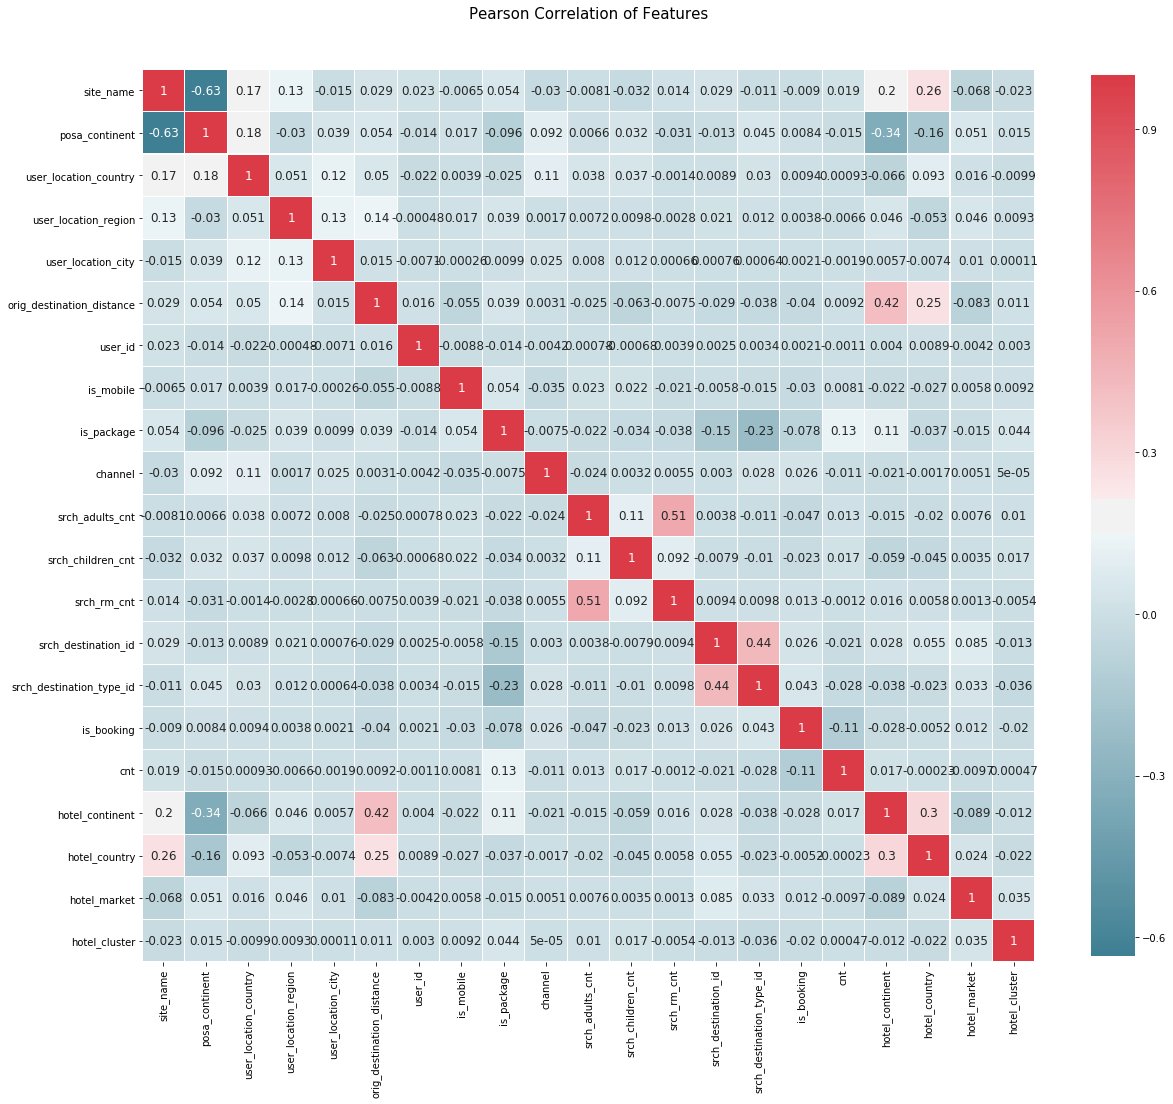

In [24]:
correlation_heatmap(sample_train_pd)

In [145]:
corr_matrix = sample_train_pd.corr()

In [146]:
corr_matrix['hotel_cluster']

site_name                  -0.024036
posa_continent              0.015397
user_location_country      -0.009582
user_location_region        0.010929
user_location_city          0.004776
user_id                     0.002483
is_mobile                   0.007957
is_package                  0.035981
channel                     0.001031
srch_adults_cnt             0.010423
srch_children_cnt           0.018259
srch_rm_cnt                -0.007572
srch_destination_id        -0.011581
srch_destination_type_id   -0.032476
is_booking                 -0.021779
cnt                         0.004396
hotel_continent            -0.015335
hotel_country              -0.027266
hotel_market                0.033480
srch_ci_yr                  0.007758
srch_ci_mn                 -0.003914
srch_ci_dy                 -0.001312
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

There is little correlation between any of the features with hotel cluster. The **is_package** feature has the maximum correlation with hotel cluster. Next are the **hotel_market** and **srch_destination_type_id**. 

**Correlation with hotel cluster in only booking data**

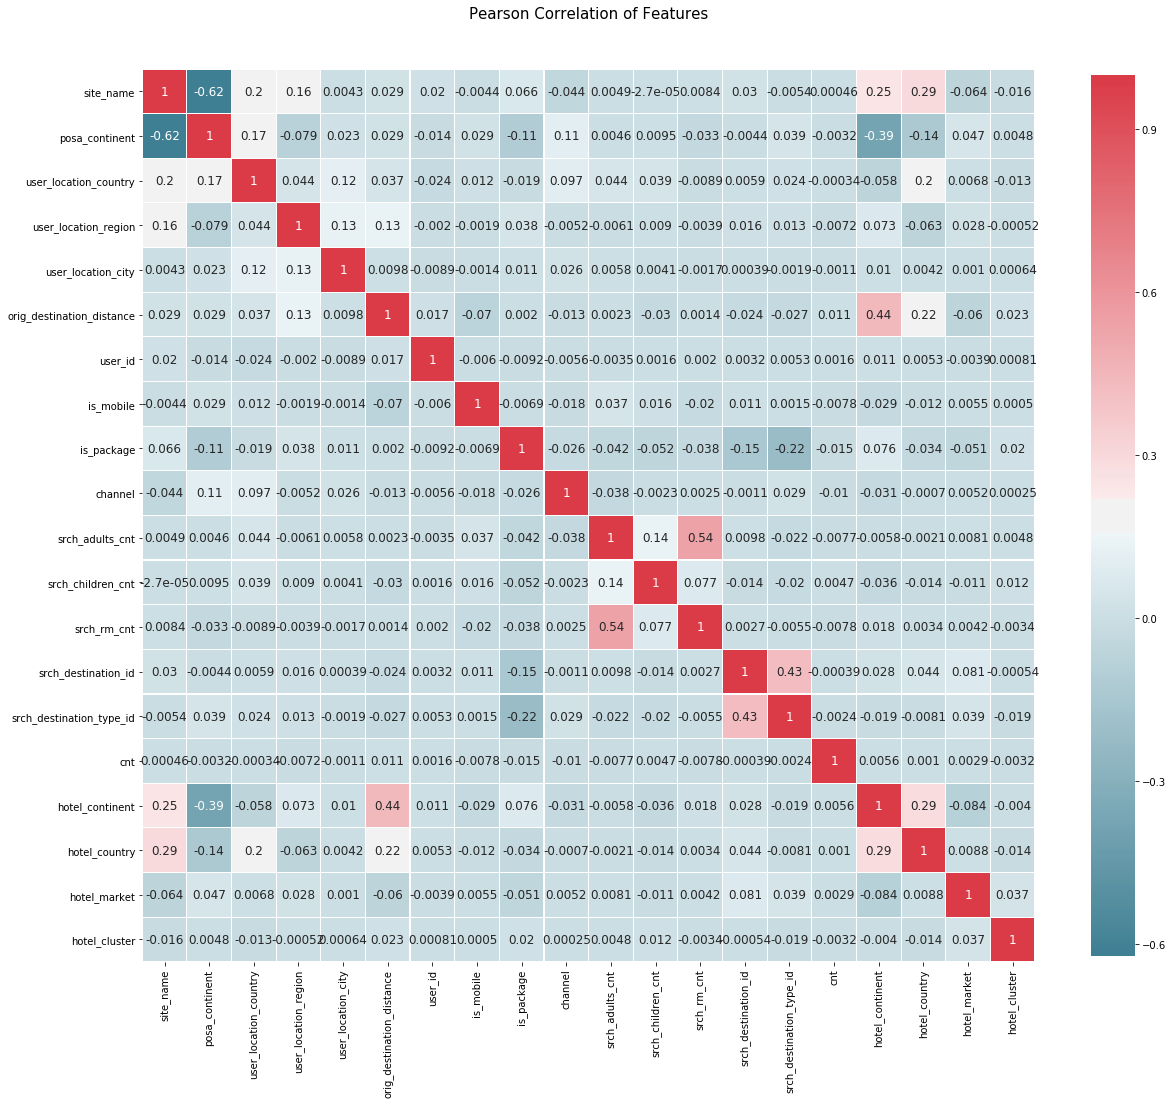

In [67]:
correlation_heatmap(sample_trainB_pd)

In [147]:
corr_matrix_B = sample_trainB_pd.corr()

In [148]:
corr_matrix_B['hotel_cluster'].fillna(0, inplace = True)

In [149]:
corr_matrix_B['hotel_cluster']

site_name                  -0.012537
posa_continent              0.000829
user_location_country      -0.014651
user_location_region        0.003704
user_location_city          0.000578
user_id                     0.000905
is_mobile                   0.003521
is_package                  0.020270
channel                     0.001405
srch_adults_cnt             0.003230
srch_children_cnt           0.011777
srch_rm_cnt                -0.006361
srch_destination_id        -0.002196
srch_destination_type_id   -0.021096
is_booking                  0.000000
cnt                         0.000021
hotel_continent            -0.002853
hotel_country              -0.010149
hotel_market                0.037571
srch_ci_yr                 -0.000433
srch_ci_mn                  0.001435
srch_ci_dy                  0.002190
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

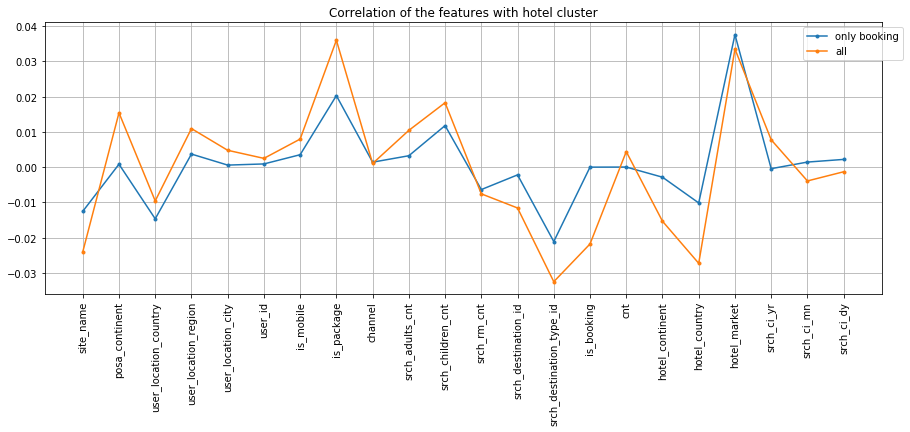

In [150]:
plt.figure(figsize=(15, 5))
plt.plot(corr_matrix_B['hotel_cluster'][0:-1], '.-', label='only booking')
plt.xticks(rotation=90)
plt.plot(corr_matrix['hotel_cluster'][0:-1], '.-', label = 'all')
plt.legend(bbox_to_anchor = (0.9, 1))
plt.title('Correlation of the features with hotel cluster')
plt.grid()

From the chart above, it is clear that the **hotel_market** has the highest correlation with the hotel_cluster both in only-booking data and all data. However, **is_package** has much less correlation with hotel_cluster in only-booking data compared to all data. This shows that is_package == 1 makes the users click way more that ususal but not neccessarily book. The above graph makes me come to the conclusion to separate the only-booking data from the click data; run two machine learning predictions on both and eventually do a linear combination/voting of the two predictions with a small weight on the click predictions. 

In [35]:
for i in range(len(test_pd['user_id'])):
    for j in range(len(sample_train_pd['user_id'])):
        if (test_pd['user_id'][i] == sample_train_pd['user_id'][j]):
            print(i, j)

In [ ]:
train_cnt_array = train.select('cnt').rdd.map(lambda row : row.cnt).sample(False, 0.0001).collect()

There seem to be not much correlation between the day, month or year of search checkin. Another interesting feature can be "how long" the user want to stay. 

In [192]:
from pyspark.sql import functions as F

In [ ]:
pd.DataFrame(train.withColumn('srch_ci', F.dayofweek(train['srch_ci'])).head(5), columns=train.columns)['srch_ci']

## 3. ML models and predictions

In [157]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [154]:
X = sample_trainB_pd.drop(['is_booking', 'hotel_cluster', 'srch_ci_yr', 'srch_ci'], axis = 1)
y = sample_trainB_pd['hotel_cluster']

In [156]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = 0.8, test_size = 0.2)

In [ ]:
lr = LogisticRegression()
lr.fit(Xtrain, y)

In [ ]:
train_sp = train_sp.withColumn('is_booking', train_sp['is_booking'].astype("float"))

In [ ]:
train_sp[['is_booking']].describe().toPandas()

In [ ]:
train_sp.where(col('is_booking').isNull())

In [ ]:
train_sp.columns

In [ ]:
test = pd.read_csv('../data/input/test.csv')

In [ ]:
chunksize = 1 * 10 ** 6
train_reader = pd.read_csv('../data/input/train.csv', chunksize=chunksize)

In [ ]:
all_chunks = []
i = 0
for chunk in train_reader:
    all_chunks.append(chunk)
    print(i)
    i += 1

In [ ]:
train = pd.DataFrame()

In [ ]:
import time

In [ ]:
for i in range(5, 10):
    start_time = time.time()
    train = pd.concat(objs = [train, all_chunks[i]], axis = 0).reset_index(drop = True)
    end_time = time.time()
    print(i)
    print(end_time - start_time)

In [ ]:
train.head()